## Background

When doing in-cage recordings, we usually put the monkey inside the plastic cage for one or two hours. We use Blackrock Cereplex-W for cortical recordings, DSPW system for EMG recordings and Ximea cameras for video recordings. Those systems are managed by a script running on the recording computer to achieve synchronization.

In order to limit the sizes of the recorded files, we write a new data file every 15 minutes. So for 2-hour long recordings we will have 8 data files. 

Data are stored in folders named by monkey name and date. For example, the folder `Pop_20201020` means the data are collected from monkey Pop on 2020-10-20.

Inside the foler `cage` there may be one or several folders named like '50ms' or '1ms', meaning data in that folder have been binned using a bin size of '50 ms' or '1 ms'. 

Inside the 'bin size' folder ('`50ms`' e.g.) there are two subfolders: `whole` and `separate`. Inside the `whole` folder the data are segmented with larger granulation. For `Pop_20201220` dataset I segmented the continuous recordings based on the typical behavior circle of the monkey during the experiment, which can be seen from video `File_4_segment_31_camera_3.avi`. 

Inside the `separate` folder the continuous recordings are further divided into shorter segments. Each segment contains only the data from one 'trial' for each behavior. Short video clips in the same folder show some typical samples.

## Codes for reading and viewing the data

### Specifying the path for the data files and import necessary packages

In [1]:
import fnmatch, os, sys
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import fnmatch, os
import pickle

def load_obj(name, path):
    if path[-1] != '/':
        path = path+'/'
    with open(path + name, 'rb') as f:
        return pickle.load(f)
    
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
############################################################################################################
############################################################################################################
base_path = 'E:/Box Sync/'
data_path = 'Pop_20201020/cage/50ms/separate'
#data_path = 'Pop_20201020/cage/50ms/whole' # If you want to read the data from roughly categorized behavior segments
############################################################################################################
############################################################################################################
file_list = fnmatch.filter(os.listdir(base_path+data_path), "*.pkl")
file_list = np.sort(file_list)   
print('These files are found in the folder: \n')
print(file_list)

These files are found in the folder: 

['Pop_20201020_separate_1.pkl' 'Pop_20201020_separate_2.pkl'
 'Pop_20201020_separate_3.pkl' 'Pop_20201020_separate_4.pkl'
 'Pop_20201020_separate_5.pkl' 'Pop_20201020_separate_6.pkl'
 'Pop_20201020_separate_7.pkl']


### As an eaxample, loading a file, say the 3rd one in `file_list`

In [2]:
behave_seg = load_obj(file_list[2], base_path + data_path)
print('behave_seg is a %s, and contains %d dictionaries.'%(type(behave_seg), len(behave_seg)))

behave_seg is a <class 'list'>, and contains 124 dictionaries.


As you can see from above, after loading the file `Pop_20201020_separate_3.pkl` we got a list named `behave_seg`. Each item of this list is a dictionary and contains the data from one identified behavior segment. '124 dictionaries' means that there are 124 different behavior segments for this file.

### Each dictionary in `behave_seg` has these fields:

In [3]:
print(behave_seg[0].keys())

dict_keys(['spike', 'EMG', 'timeframe', 'label', 'EMG_names', 'unit_names', 'raw_EMG', 'raw_EMG_timeframe', 'raw_EMG_fs', 'spike_timing'])


* __spike__: is actually the binned spike counts. The data files in this folder are all binned with 50 ms bins (20 Hz). __spike__ is an array, in which each column is a 'neuron' and each row is a time point
* __EMG__: is actually the EMG envelops after rectifying and 10 Hz low-pass filtering. It has the same sampling rate as the spike counts, here 20 Hz. Likewise, each column is a muscle, and each row is a temporal sample
* __timeframe__: is the time frame for the binned spike counts and filtered EMGs
* __label__: is the type of the behavior of one behavior segment, like "crawling", "picking treats" or "pg" (power grasping)
* __EMG_names__: is the names of each EMG channel
* __unit_names__: is the names of each cortical channel. Since no spike sorting, here it is actually the labels for the electrodes
* __raw_EMG__: is the raw EMG signals sampled with the original sampling frequency, without filtering or down-sampling. The sampling frequency of the raw EMG signals is stored in the field __`raw_EMG_fs`__. Similar to __`EMG`__, each column correspond to a muscle
* __raw_EMG_timeframe__: is the time frame for the raw EMG signals. Notice that it is different from the __`timeframe`__
* __raw_EMG_fs__: is the sampling frequency for raw EMGs
* __spike_timing__: is the timing of the spikes

### Two useful functions for viewing the signals

In [4]:
def plot_behave_dict_spike_timing(behave_dict, plot_t, bin_size, EMG_chs = 0):
    print(behave_dict['label'])
    if plot_t == 0:
        plot_len = behave_dict['spike'].shape[0]
    else:
        plot_len = int(plot_t/bin_size)
    if EMG_chs == 0:
        EMG_chs = np.arange(behave_dict['EMG'].shape[1])        
    p_names = behave_dict['EMG_names']
    N = len(EMG_chs)
    spike_grid = 5
    p_spike, p_emg = behave_dict['spike'], behave_dict['EMG']
    plot_start = 0
    grid = plt.GridSpec(N+spike_grid,1,wspace=0.5,hspace=0.2)
    main_ax = plt.subplot(grid[0:spike_grid,0])
    for i, spiketrain in enumerate(behave_dict['spike_timing']):
        main_ax.plot(spiketrain-behave_dict['timeframe'][0], np.ones_like(spiketrain) * i, ls='', marker='|', color = 'k', ms = 1)
    if plot_t == 0:
        plt.xlim([0, behave_dict['timeframe'][-1]-behave_dict['timeframe'][0]])
    else:
        plt.xlim([0, plot_t])
    x=np.arange(plot_len)*bin_size
    main_ax.axis('off')
    plt.xticks(color = 'w')
    plt.yticks([])
    for i in range(N):
        ax0 = plt.subplot(grid[i+spike_grid,0], sharex = main_ax)
        p1 = p_emg[plot_start:plot_start+plot_len, EMG_chs[i]]
        #plt.yticks([])
        frame = plt.gca()
        frame.axes.get_yaxis().set_visible(False)
        ax0.spines['top'].set_visible(False)
        ax0.spines['right'].set_visible(False)
        ax0.spines['left'].set_visible(False)
        if i<N-1:
            plt.plot(x, p1, 'k')
            ax0.spines['bottom'].set_visible(False)
            plt.setp(ax0.get_xticklabels(),visible=False)
            ax0.tick_params(axis=u'both', which=u'both',length=0)
        if i == N-1:
            ax0.tick_params(axis=u'both', which=u'both',length=4)
            plt.setp(ax0.get_xticklabels(),visible=True)
            plt.plot(x, p1, 'k')
            plt.xticks(color='k')
            ax0.set_xlabel('Time (s)', fontsize = 22)
            plt.tick_params(labelsize=22)
        
        plt.text(x[-10], np.max(p1),'%s' %(p_names[EMG_chs[i]]),fontsize = 18, color = 'k',
                  verticalalignment="top",horizontalalignment="left")
        
def plot_behave_dict_spike_timing_raw_EMG(behave_dict, plot_t, EMG_chs = 0):
    print(behave_dict['label'])
    if plot_t == 0:
        plot_len = behave_dict['raw_EMG'].shape[0]
    else:
        plot_len = int(plot_t*behave_dict['raw_EMG_fs'])
    if EMG_chs == 0:
        EMG_chs = np.arange(behave_dict['raw_EMG'].shape[1])        
    p_names = behave_dict['EMG_names']
    N = len(EMG_chs)
    spike_grid = 5
    p_spike, p_emg = behave_dict['spike'], behave_dict['raw_EMG']
    plot_start = 0
    grid = plt.GridSpec(N+spike_grid,1,wspace=0.5,hspace=0.2)
    main_ax = plt.subplot(grid[0:spike_grid,0])
    for i, spiketrain in enumerate(behave_dict['spike_timing']):
        main_ax.plot(spiketrain-behave_dict['timeframe'][0], np.ones_like(spiketrain) * i, ls='', marker='|', color = 'k', ms = 1)
    if plot_t == 0:
        plt.xlim([0, behave_dict['raw_EMG_timeframe'][-1]-behave_dict['raw_EMG_timeframe'][0]])
    else:
        plt.xlim([0, plot_t])
    x=np.arange(plot_len)/behave_dict['raw_EMG_fs']
    if behave_dict['label'] == 'pg':
        fsr_ax = main_ax.twinx()
        t_fsr = behave_dict['timeframe'] - behave_dict['timeframe'][0]
        fsr_ax.plot(t_fsr, behave_dict['FSR_data'][:, 0], 'blue')
        fsr_ax.plot(t_fsr, behave_dict['FSR_data'][:, 1], 'royalblue')
        fsr_ax.axis('off')
    main_ax.axis('off')
    plt.xticks(color = 'w')
    plt.yticks([])
    for i in range(N):
        ax0 = plt.subplot(grid[i+spike_grid,0], sharex = main_ax)
        p1 = p_emg[plot_start:plot_start+plot_len, EMG_chs[i]]
        frame = plt.gca()
        frame.axes.get_yaxis().set_visible(False)
        ax0.spines['top'].set_visible(False)
        ax0.spines['right'].set_visible(False)
        ax0.spines['left'].set_visible(False)
        if i<N-1:
            plt.plot(x, p1, 'k')
            ax0.spines['bottom'].set_visible(False)
            plt.setp(ax0.get_xticklabels(),visible=False)
            ax0.tick_params(axis=u'both', which=u'both',length=0)
        if i == N-1:
            ax0.tick_params(axis=u'both', which=u'both',length=4)
            plt.setp(ax0.get_xticklabels(),visible=True)
            plt.plot(x, p1, 'k')
            plt.xticks(get_time_ticks(x), color='k')
            ax0.set_xlabel('Time (s)', fontsize = 22)
            plt.tick_params(labelsize=20)
        
        plt.text(x[-10], np.max(p1),'%s' %(p_names[EMG_chs[i]]),fontsize = 18, color = 'k',
                  verticalalignment="top",horizontalalignment="left")
        
def get_time_ticks(x):
    if x[-1]>3:
        my_xticks = np.arange(0, x[-1], 1)
    elif (x[-1]<3)&(x[-1]>1.5):
        my_xticks = np.arange(0, x[-1], 0.5)
    elif x[-1]<1.5:
        my_xticks = np.arange(0, x[-1], 0.3)
    return my_xticks


### Viewing the spike timing and filtered EMGs for crawling

crawling


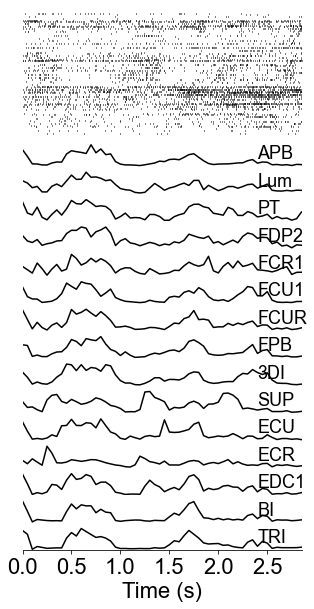

In [5]:
fig = plt.figure(figsize=(5, 10))
plot_behave_dict_spike_timing(behave_seg[13], 0, 0.05)

### Viewing the spike timings and raw EMGs for crawling

crawling


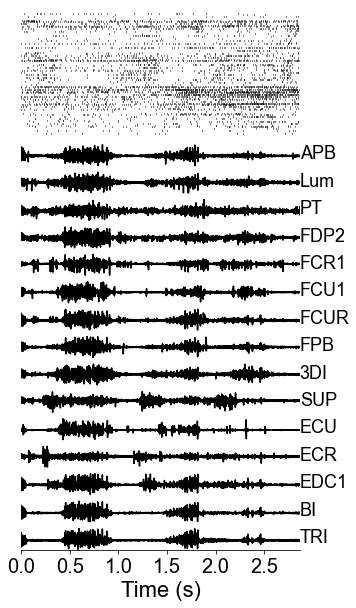

In [6]:
fig = plt.figure(figsize=(5, 10))
plot_behave_dict_spike_timing_raw_EMG(behave_seg[13], 0)

### Viewing the spike timing and raw EMGs for power grasping (pg)

pg


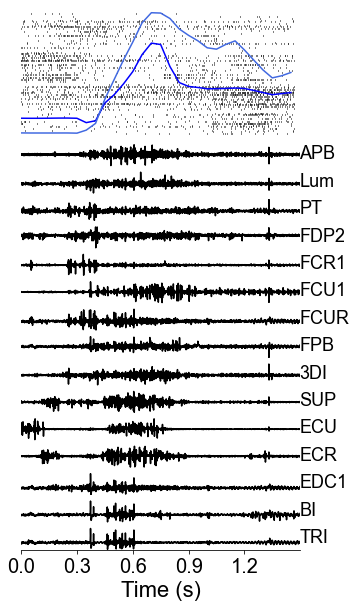

In [7]:
fig = plt.figure(figsize=(5, 10))
plot_behave_dict_spike_timing_raw_EMG(behave_seg[34], 0)

### Viewing the spike timing and raw EMGs for picking treats

high picking treats


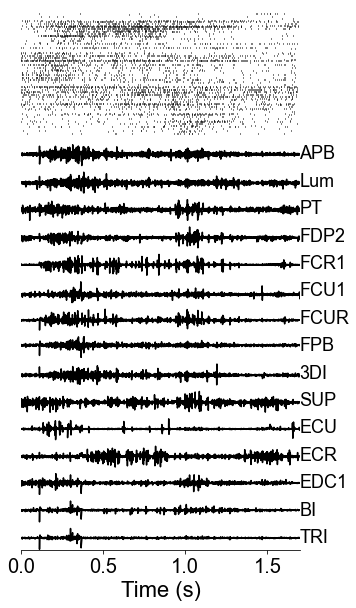

In [8]:
fig = plt.figure(figsize=(5, 10))
plot_behave_dict_spike_timing_raw_EMG(behave_seg[68], 0)

In the cell above, 'high picking treats' means that the monkey reached a higher location to pick the treats

### Some additional functions which may be useful

Loading all .pkl files in a folder

In [9]:
def load_behave_segs(path):
    file_list = fnmatch.filter(os.listdir(path), "*.pkl")
    file_list = np.sort(file_list)   
    behave_seg_all = []
    for i in range(len(file_list)):
        behave_seg_all.append(load_obj(file_list[i], path))
        print('The file %s has been loaded'%(file_list[i]))
    return behave_seg_all

behave_seg_all = load_behave_segs(base_path + data_path)
print('Here behave_seg_all contains %d lists'%(len(behave_seg_all)))

The file Pop_20201020_separate_1.pkl has been loaded
The file Pop_20201020_separate_2.pkl has been loaded
The file Pop_20201020_separate_3.pkl has been loaded
The file Pop_20201020_separate_4.pkl has been loaded
The file Pop_20201020_separate_5.pkl has been loaded
The file Pop_20201020_separate_6.pkl has been loaded
The file Pop_20201020_separate_7.pkl has been loaded
Here behave_seg_all contains 7 lists


Here `behave_seg_all` is a list of 'lists'. Each item in `behave_seg_all` corresponds to the behavior segments in an individual `.pkl` file. You can get the data for the 53th behavior segment of the 5th .pkl file by calling `behave_seg_all[4][52]`

The functions below can be used to extract spike counts, EMGs or raw EMGs from all segments of a specified behavior from `behave_seg_all`. The behavior is specified by the parameter `cat_str`

In [10]:
def pull_data_from_behave_seg_all(behave_seg_all, cat_str):
    spike, emg = [], []
    for behave_seg in behave_seg_all:
        for each in behave_seg:
            if each['label'] == cat_str:
                spike.append(each['spike'])
                emg.append(each['EMG'][:, :])
    return spike, emg  

def pull_raw_EMG_from_behave_seg_all(behave_seg_all, cat_str):
    raw_emg = []
    for behave_seg in behave_seg_all:
        for each in behave_seg:
            if each['label'] == cat_str:
                raw_emg.append(each['raw_EMG'][:, :])
    return raw_emg    
   


`cat_str` is one of these:
* __crawling__: 'crawling'    
* __power grasping__: 'pg'
* __picking treats from a high location__: 'high picking treats'
* __picking treats from a low location__: 'low picking treats'

For example, if you want to pull data from the 'power grasping' behavior, you can just let `cat_str = 'pg'`. If you want to read the data in the folder `../whole`, then the value of `cat_str` can be only `whole`. 

By running the codes below you can get the spike counts and filtered EMGs from all crawling segments in all of the 7 files. The spike counts are stored in `crawling_spike`, and the filtered EMG in `crawling_EMG`

In [11]:
crawling_spike, crawling_EMG = pull_data_from_behave_seg_all(behave_seg_all, 'crawling')
print('There are in total %d crawling segments in these 7 files'%(len(crawling_spike)))

There are in total 494 crawling segments in these 7 files


And by running the codes below you can get the raw EMGs for all 'crawling' and 'high picking treats' segments. Here I'm using 'htreats' to represent the meaning of 'picking treats from a high location'

In [12]:
crawling_raw_EMG = pull_raw_EMG_from_behave_seg_all(behave_seg_all, 'crawling')
print('There are in total %d crawling segments in these 7 files'%(len(crawling_raw_EMG)))

htreats_raw_EMG = pull_raw_EMG_from_behave_seg_all(behave_seg_all, 'high picking treats')
print('There are in total %d high picking treats segments in these 7 files'%(len(htreats_raw_EMG)))

There are in total 494 crawling segments in these 7 files
There are in total 94 high picking treats segments in these 7 files
